In [1]:
from environment.hydroenv import HydroEnv
from algorithms import DynamicProgramming, Qlearning
from algorithms.dqn import ReplayBuffer, DQN, DQNAgent
from algorithms.reinforce import ReinforceAgent

import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
import gym

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import random
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

## Q learning

In [2]:
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

env = HydroEnv(
    t = 3,
    l_max = 100,
    l_min = 0,
    punition = -100
)

Q_model = Qlearning(
    env = env,
    gamma = 0.95,
    episodes = 300000,
    learning_rate = 1,
    learning_rate_decay = 1,
    epsilon = 1,
    epsilon_decay = 0.999945, #0.999945
    min_epsilon = 0.2
)

epsilon_history, reward_history_Q = Q_model.qlearning_solver()

ep: 0 %: 0.0 %
epsilon: 1
learning rate: 1 
ep: 10000 %: 3.3333333333333335 %
epsilon: 0.5769410837604694
learning rate: 1 
ep: 20000 %: 6.666666666666667 %
epsilon: 0.3328610141306998
learning rate: 1 
ep: 30000 %: 10.0 %
epsilon: 0.2
learning rate: 1 
ep: 40000 %: 13.333333333333334 %
epsilon: 0.2
learning rate: 1 
ep: 50000 %: 16.666666666666664 %
epsilon: 0.2
learning rate: 1 
ep: 60000 %: 20.0 %
epsilon: 0.2
learning rate: 1 
ep: 70000 %: 23.333333333333332 %
epsilon: 0.2
learning rate: 1 
ep: 80000 %: 26.666666666666668 %
epsilon: 0.2
learning rate: 1 
ep: 90000 %: 30.0 %
epsilon: 0.2
learning rate: 1 
ep: 100000 %: 33.33333333333333 %
epsilon: 0.2
learning rate: 1 
ep: 110000 %: 36.666666666666664 %
epsilon: 0.2
learning rate: 1 
ep: 120000 %: 40.0 %
epsilon: 0.2
learning rate: 1 
ep: 130000 %: 43.333333333333336 %
epsilon: 0.2
learning rate: 1 
ep: 140000 %: 46.666666666666664 %
epsilon: 0.2
learning rate: 1 
ep: 150000 %: 50.0 %
epsilon: 0.2
learning rate: 1 
ep: 160000 %: 53.

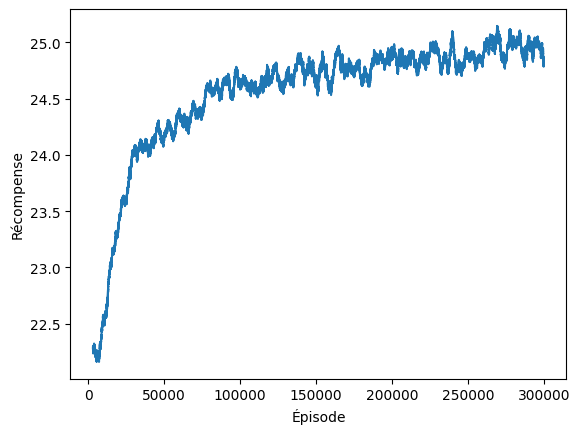

In [3]:
window = 3000
data = np.array(reward_history_Q)
moving_avg = np.convolve(data, np.ones(window)/window, mode='valid')
xticks_Q = [ep for ep in range(Q_model.episodes)]

plt.plot(xticks_Q[window-1:], moving_avg)
plt.ticklabel_format(style = 'plain')
plt.xlabel('Épisode')
plt.ylabel('Récompense')
# plt.savefig('/Users/oli.dmrs/Library/CloudStorage/OneDrive-HECMontréal/StageHEC2025/images_graph/q-learning_v2.png')
plt.show()

In [ ]:
# def simulation(n : int) -> np.ndarray:
#     results = np.zeros(n)
#     count_non_visted = 0
#     for n in range(n):
#         pi, waterlevel, inflows = Q_model.extract_policy(40)
#         output = Q_model.extract_reward_of_pi(waterlevel, pi)
#         count_non_visted += Q_model.compute_non_visited_count(waterlevel, inflows, pi)
#         results[n] = output
#     return results, count_non_visted

# results, non_visited = simulation(5000) 
# print(non_visited)
# print(np.mean(results))
# print(np.std(results))

6
17.806536879185785
1.6434852872884864


## DQN

In [3]:
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

episodes = 500000

batch_size = 32
update_target = 300

# Definition of the environment
env = HydroEnv(
    t = 3,
    l_max = 100,
    l_min = 0,
    punition = -50
)

# Definition of the DQN agent
dqn_agent = DQNAgent(
    input_dim = env.observation_space.shape[0],
    output_dim = env.action_space.n * 2,
    nb_hidden = 2,
    hidden_size = 100,
    replay_buffer = ReplayBuffer(5000),
    learning_rate = 0.001,
    env = env,
    gamma = 0.9,
    init_eps = 1,
    final_eps = 0.1,
    eps_decay_rate = 0.9999969,
    learning_decay_rate = 1,
    final_learning_rate = 0.000005
)

# 0.99999975
reward_history = []
truncated_history = []
epsilon_history_DQN = []
count_truncated = 0
for episode in range(episodes):
    # Reset environment which implies randomly generating a state
    env.reset()
    episode_reward = 0
    epsilon_history_DQN.append(dqn_agent.eps)
    dqn_agent.epsilon_decay()
    if episode % update_target == 0:
        dqn_agent.update_target_network()
    
    for t in range(env.t):
        state = env.state
        action, truncated_from_action = dqn_agent.choose_action(state)
        
        next_state, reward, done, truncated, info = env.step(action)

        dqn_agent.replay_buffer.add(state, action, reward, next_state, done)
        dqn_agent.update(batch_size)
        episode_reward += reward

        if done or truncated:
            if truncated:
                count_truncated += 1
                truncated_history.append(episode)
            break
    
    reward_history.append(episode_reward)
    dqn_agent.alpha_decay()
    if episode % 10000 == 0:
        print(f'Episode: {episode}, % of episodes: {episode/episodes * 100} %')
        print(f'epsilon: {round(dqn_agent.eps, 2)}')
        print(f'alpha: {dqn_agent.learning_rate}')

print(f'\n\n % of decisions which were eploration: {dqn_agent.exploration_episodes/(dqn_agent.exploration_episodes + dqn_agent.exploitation_episodes) * 100} %')
print(f'% of truncated decisions: {count_truncated/(dqn_agent.exploration_episodes + dqn_agent.exploitation_episodes) * 100} %')
dqn_agent.exploitation_episodes = 0
dqn_agent.exploration_episodes = 0

Episode: 0, % of episodes: 0.0 %
epsilon: 1.0
alpha: 0.001
Episode: 10000, % of episodes: 2.0 %
epsilon: 0.97
alpha: 0.001
Episode: 20000, % of episodes: 4.0 %
epsilon: 0.94
alpha: 0.001
Episode: 30000, % of episodes: 6.0 %
epsilon: 0.91
alpha: 0.001
Episode: 40000, % of episodes: 8.0 %
epsilon: 0.88
alpha: 0.001
Episode: 50000, % of episodes: 10.0 %
epsilon: 0.86
alpha: 0.001
Episode: 60000, % of episodes: 12.0 %
epsilon: 0.83
alpha: 0.001
Episode: 70000, % of episodes: 14.000000000000002 %
epsilon: 0.8
alpha: 0.001
Episode: 80000, % of episodes: 16.0 %
epsilon: 0.78
alpha: 0.001
Episode: 90000, % of episodes: 18.0 %
epsilon: 0.76
alpha: 0.001
Episode: 100000, % of episodes: 20.0 %
epsilon: 0.73
alpha: 0.001
Episode: 110000, % of episodes: 22.0 %
epsilon: 0.71
alpha: 0.001
Episode: 120000, % of episodes: 24.0 %
epsilon: 0.69
alpha: 0.001
Episode: 130000, % of episodes: 26.0 %
epsilon: 0.67
alpha: 0.001
Episode: 140000, % of episodes: 28.000000000000004 %
epsilon: 0.65
alpha: 0.001
Epi

In [ ]:
# # Load model weights from file
# dqn_agent.dqn.load_state_dict(torch.load("/Users/oli.dmrs/Library/CloudStorage/OneDrive-HECMontréal/StageHEC2025/models/final_dqn_model.pth"))
# print("Model loaded from dqn_model.pth")


Model loaded from dqn_model.pth


/var/folders/31/tgbtq8w94_q5gd2k_bswhf800000gn/T/ipykernel_76830/226766543.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dqn_agent.dqn.load_state_dict(torch.load("/Use

In [ ]:
# # Save the model weights to a file
# torch.save(dqn_agent.dqn.state_dict(), "/Users/oli.dmrs/Library/CloudStorage/OneDrive-HECMontréal/StageHEC2025/models/final_dqn_model.pth")
# print("Model saved to dqn_model.pth")


Model saved to dqn_model.pth


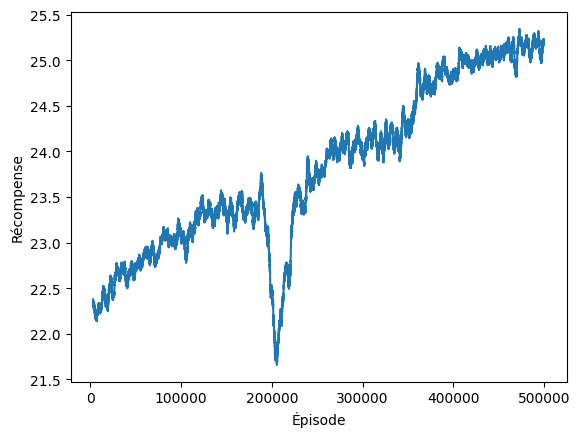

In [8]:
window = 3000
def set_window(rewards):
    data = np.array(rewards)
    moving_avg = np.convolve(data, np.ones(window)/window, mode='valid')
    return moving_avg
xticks = [ep for ep in range(episodes)]
plt.plot(xticks[window-1:], set_window(list_reward[0])) #new
plt.xlabel('Épisode')
plt.ylabel('Récompense')
plt.savefig('/Users/oli.dmrs/Library/CloudStorage/OneDrive-HECMontréal/StageHEC2025/images_graph/DQN_new_rewards')
plt.show()

In [ ]:
def simulation(n : int):
    dqn_cumulative = np.zeros(n)
    qlearning_cumulative = np.zeros(n)
    nb_qlearning_nonvisited = 0
    for episode in range(n):
        dqn_reward = 0
        qlearning_reward = 0
        env.reset()
        waterlevel_dqn = 40
        waterlevel_q = 40
        for t in range(env.t):
            i = env.get_inflow(t)
            dqn_action = dqn_agent.dqn.act(dqn_agent.dqn.forward(torch.tensor([waterlevel_dqn, i, t], dtype=torch.float32)))
            waterlevel_dqn = waterlevel_dqn + i - dqn_action
            dqn_reward += env.get_current_reward(t, waterlevel_dqn, dqn_action)[0]

            q_action = np.argmax(Q_model.Q_table[t, waterlevel_q, i, :])
            if Q_model.visit_counts[t, waterlevel_q, i, q_action] == 0.0:
                nb_qlearning_nonvisited += 1
            waterlevel_q = waterlevel_q + i - q_action
            qlearning_reward += env.get_current_reward(t, waterlevel_q, q_action)[0]
            
        dqn_cumulative[episode] = dqn_reward
        qlearning_cumulative[episode] = qlearning_reward
    return dqn_cumulative, qlearning_cumulative, nb_qlearning_nonvisited

dqn_cumulative, qlearning_cumulative, nb_qlearning_nonvisited = simulation(5000) 

In [ ]:
print(dqn_cumulative)
print(qlearning_cumulative)
print(nb_qlearning_nonvisited)

print(dqn_cumulative.mean())
print(qlearning_cumulative.mean())
print('')
print(dqn_cumulative.std())
print(qlearning_cumulative.std())

[17.68309671 18.7254146  17.95037499 ... 18.22530799 18.83077512
 17.61657519]
[13.81342839 17.55780944 17.96434899 ... 16.80713842 17.63114072
 17.02903963]
1
13.707885030868004
17.040970360128995

21.912860601431987
1.4227789757612979


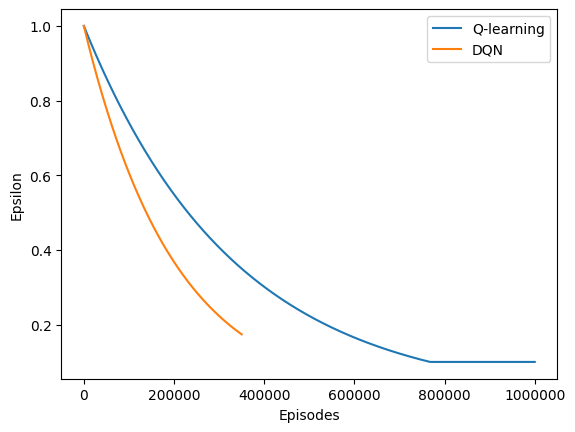

In [ ]:
xticks = [ep for ep in range(1000000)]
# plt.xticks(xticks)

plt.plot(xticks, epsilon_history, label = 'Q-learning')
  
plt.ticklabel_format(style = 'plain')
plt.plot(epsilon_history_DQN, label = 'DQN')
plt.legend()
plt.xlabel('Episodes')
plt.ylabel('Epsilon')
plt.savefig('images/epsilon-comparaison.png')
plt.show()

## REINFORCE

In [144]:
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

episodes_reinforce = 80000
batch_size = 32

env = HydroEnv(
    t = 3,
    l_max = 100,
    l_min = 0,
    punition = -50
)

reinforce = ReinforceAgent(
    input_dim = env.observation_space.shape[0],
    output_dim = env.action_space.n * 2,
    nb_hidden = 2,
    hidden_size = 100,
    gamma = 0.9,
    env = env,
    learning_rate = 0.00001, 
    learning_decay_rate = 1,
    final_learning_rate = 0.0001,
    beta = 0.4,
    beta_decay_rate = 0.99995
)
discounted_rewards_batch = []
reward_history_reinforce = []
states_batch = []
actions_batch = []

for episode in range(episodes_reinforce):
    # print(episode)
    if episode % 1000 == 0: 
        print(f'Episode: {episode}, % of episodes: {episode/episodes_reinforce * 100} %')
        print(f'learning rate: {reinforce.learning_rate:.10f}')
        print(f'beta: {reinforce.beta:.10f}')
    
    actions, states, rewards = reinforce.gather_an_episode()
    discounted_rewards = reinforce.discount_rewards(rewards)
    discounted_rewards_batch.append(discounted_rewards)
    states_batch.append(states)
    actions_batch.append(actions)

    if len(discounted_rewards_batch) == batch_size:
        reinforce.update(states_batch, actions_batch, discounted_rewards_batch)
        discounted_rewards_batch = []
        states_batch = []
        actions_batch = []

    reward_history_reinforce.append(sum(rewards))
    # reinforce.alpha_decay()
    reinforce.beta_decay()

Episode: 0, % of episodes: 0.0 %
learning rate: 0.0000100000
beta: 0.4000000000
Episode: 1000, % of episodes: 1.25 %
learning rate: 0.0000100000
beta: 0.3804912942
Episode: 2000, % of episodes: 2.5 %
learning rate: 0.0000100000
beta: 0.3619340623
Episode: 3000, % of episodes: 3.75 %
learning rate: 0.0000100000
beta: 0.3442818995
Episode: 4000, % of episodes: 5.0 %
learning rate: 0.0000100000
beta: 0.3274906637
Episode: 5000, % of episodes: 6.25 %
learning rate: 0.0000100000
beta: 0.3115183662
Episode: 6000, % of episodes: 7.5 %
learning rate: 0.0000100000
beta: 0.2963250658
Episode: 7000, % of episodes: 8.75 %
learning rate: 0.0000100000
beta: 0.2818727694
Episode: 8000, % of episodes: 10.0 %
learning rate: 0.0000100000
beta: 0.2681253371
Episode: 9000, % of episodes: 11.25 %
learning rate: 0.0000100000
beta: 0.2550483912
Episode: 10000, % of episodes: 12.5 %
learning rate: 0.0000100000
beta: 0.2426092311
Episode: 11000, % of episodes: 13.750000000000002 %
learning rate: 0.0000100000
b

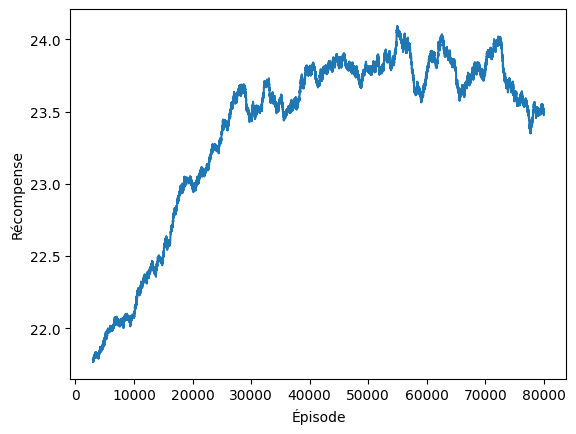

In [145]:
window = 3000
data = np.array(reward_history_reinforce)
moving_avg = np.convolve(data, np.ones(window)/window, mode='valid')
xticks_Q = [ep for ep in range(episodes_reinforce)]

plt.plot(xticks_Q[window-1:], moving_avg)
plt.ticklabel_format(style = 'plain')
plt.xlabel('Épisode')
plt.ylabel('Récompense')
# plt.savefig('/Users/oli.dmrs/Library/CloudStorage/OneDrive-HECMontréal/StageHEC2025/images_graph/REINFORCE.png')
plt.show()

## Comparison

## Dynamic Programming

In [92]:
np.random.seed(1)
i0 = int(max(10 + 5 * np.random.normal(loc = 0, scale = 1), 0))
i1 = int(max(i0 + 5 * np.random.normal(loc = 0, scale = 1), 0))
i2 = int(max(2 * i1 + 5 * np.random.normal(loc = 0, scale = 1), 0))

env = HydroEnv(
    t = 3,
    l_max = 100,
    l_min = 0,
    punition = -100,
    deterministic_inflows = [i0, i1, i2]
)

dp = DynamicProgramming(
    env
)
v, pi = dp.dynamic_prog_solution2()

print(f'Waterinflows: {i0, i1, i2}')
pi_t0, waterlevels_t0, reward = dp.policy_extraction(pi, 90)
print(f'Actions taken starting at l0 = 40: {pi_t0}')
print(f'Waterlevels for each timestep: {waterlevels_t0}')
print(f'Reward: {reward}')

Waterinflows: (18, 14, 25)
Actions taken starting at l0 = 40: [18, 24, 35]
Waterlevels for each timestep: [90, 90, 80, 70]
Reward: 31.68836166427952


In [14]:
# QLEARNING QLEARNING QLEARNING QLEARNING

np.random.seed(1)
i0 = int(max(10 + 5 * np.random.normal(loc = 0, scale = 1), 0))
i1 = int(max(i0 + 5 * np.random.normal(loc = 0, scale = 1), 0))
i2 = int(max(2 * i1 + 5 * np.random.normal(loc = 0, scale = 1), 0))

pi_Q, waterlevel_Q, inflow_Q, reward = Q_model.extract_policy(40, [i0, i1, i2, 0])

print(f'Waterinflows: {inflow_Q}')
print(f'Actions taken starting at l0 = 40: {pi_Q}')
print(f'Waterlevels for each timestep: {waterlevel_Q}')
print(f'Reward: {reward}')

Waterinflows: [18, 14, 25, 0]
Actions taken starting at l0 = 40: [1, 22, 32]
Waterlevels for each timestep: [40, 57, 49, 42]
Reward: 26.53358727202157


In [15]:
#DQN DQN DQN DQN DQN

np.random.seed(1)
i0 = int(max(10 + 5 * np.random.normal(loc = 0, scale = 1), 0))
i1 = int(max(i0 + 5 * np.random.normal(loc = 0, scale = 1), 0))
i2 = int(max(2 * i1 + 5 * np.random.normal(loc = 0, scale = 1), 0))
inflows = [i0, i1, i2, 0]
l = 40
waterlevel_dqn = [l]
dqn_actions = []
dqn_reward = 0
for t in range(env.t + 1):
    dqn_action = dqn_agent.dqn.act(dqn_agent.dqn.forward(torch.tensor([l, inflows[t], t], dtype=torch.float32)))
    dqn_reward += env.get_current_reward(t, l, dqn_action)[0]
    l = l + inflows[t] - dqn_action
    if t != env.t:
        waterlevel_dqn.append(l)
        dqn_actions.append(dqn_action)
    

print(f'Waterinflows: {inflows}')
print(f'Actions taken starting at l0 = 40: {dqn_actions}')
print(f'Waterlevels for each timestep: {waterlevel_dqn}')
print(f'Reward: {dqn_reward}')

Waterinflows: [18, 14, 25, 0]
Actions taken starting at l0 = 40: [14, 18, 20]
Waterlevels for each timestep: [40, 44, 40, 45]
Reward: 27.588101034149197


In [136]:
#REINFORCE REINFORCE REINFORCE


np.random.seed(1)
i0 = int(max(10 + 5 * np.random.normal(loc = 0, scale = 1), 0))
i1 = int(max(i0 + 5 * np.random.normal(loc = 0, scale = 1), 0))
i2 = int(max(2 * i1 + 5 * np.random.normal(loc = 0, scale = 1), 0))
inflows = [i0, i1, i2, 0]
l = 90
waterlevel_reinforce = [l]
reinforce_actions = []
reinforce_reward = 0
for t in range(env.t + 1):
    actions = reinforce.policynetwork.forward(torch.tensor([l, inflows[t], t], dtype=torch.float32))
    min_valid_action_space = max(0, l + inflows[t] - env.l_max)
    max_valid_action_space = min(l + inflows[t], env.l_max) + 1
    reinforce_action = reinforce.policynetwork.act(actions, min_valid_action_space, max_valid_action_space)
    reinforce_reward += env.get_current_reward(t, l, reinforce_action)[0]
    l = l + inflows[t] - reinforce_action
    if t != env.t:
        waterlevel_reinforce.append(l)
        reinforce_actions.append(reinforce_action)
    

print(f'Waterinflows: {inflows}')
print(f'Actions taken starting at l0 = 40: {reinforce_actions}')
print(f'Waterlevels for each timestep: {waterlevel_reinforce}')
print(f'Reward: {reinforce_reward}')

Waterinflows: [18, 14, 25, 0]
Actions taken starting at l0 = 40: [19, 19, 19]
Waterlevels for each timestep: [90, 89, 84, 90]
Reward: 31.462236267033102


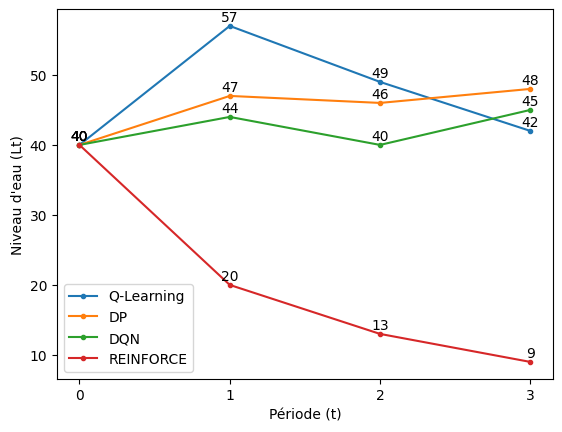

In [18]:
x = [0,1,2,3]

plt.plot(x, waterlevel_Q, marker = '.', label = 'Q-Learning')
plt.plot(x, waterlevels_t0, marker = '.', label = 'DP')
plt.plot(x, waterlevel_dqn, marker = '.', label = 'DQN')
plt.plot(x, waterlevel_reinforce, marker = '.', label = 'REINFORCE')
for i, txt in enumerate(waterlevel_Q):
    plt.text(x[i], waterlevel_Q[i] + 0.2, str(txt), ha='center', va='bottom')
for i, txt in enumerate(waterlevels_t0):
    plt.text(x[i], waterlevels_t0[i] + 0.2, str(txt), ha='center', va='bottom')
for i, txt in enumerate(waterlevel_dqn):
    plt.text(x[i], waterlevel_dqn[i] + 0.2, str(txt), ha='center', va='bottom')
for i, txt in enumerate(waterlevel_reinforce):
    plt.text(x[i], waterlevel_reinforce[i] + 0.2, str(txt), ha='center', va='bottom')
locator = ticker.MultipleLocator(1)
plt.gca().xaxis.set_major_locator(locator)
plt.xlabel('Période (t)')
plt.ylabel("Niveau d'eau (Lt)")
plt.legend()
plt.savefig('/Users/oli.dmrs/Library/CloudStorage/OneDrive-HECMontréal/StageHEC2025/images_graph/DPvsQlearning.png')
plt.show()

In [147]:
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

def simulation(n : int):
    dp_cumulative = np.zeros(n)
    qlearning_cumulative = np.zeros(n)
    dqn_cumulative = np.zeros(n)
    reinforce_cumulative = np.zeros(n)
    nb_qlearning_nonvisited = 0
    for episode in range(n):
        waterlevel_t0 = random.randint(0,99)

        if episode % 1000 == 0:
            print(episode)

        qlearning_reward = 0
        dqn_reward = 0
        reinforce_reward = 0
        env.reset()

        waterlevel_q = waterlevel_t0
        waterlevel_dqn = waterlevel_t0
        waterlevel_reinforce = waterlevel_t0
        i0 = int(max(10 + 5 * np.random.normal(loc = 0, scale = 1), 0))
        i1 = int(max(i0 + 5 * np.random.normal(loc = 0, scale = 1), 0))
        i2 = int(max(2 * i1 + 5 * np.random.normal(loc = 0, scale = 1), 0))
        inflows = [i0, i1, i2, 0]
        dp_env = HydroEnv(
            t = 3,
            l_max = 100,
            l_min = 0,
            punition = -100,
            deterministic_inflows = inflows
        )

        dp = DynamicProgramming(dp_env)
        v, pi = dp.dynamic_prog_solution2()
        pi_t0, waterlevels_t0, reward = dp.policy_extraction(pi, waterlevel_t0)
        dp_cumulative[episode] = reward
        
        for t in range(env.t):
            
            q_values_dqn = dqn_agent.dqn.forward(torch.tensor([waterlevel_dqn, inflows[t], t], dtype=torch.float32))
            min_valid_action_space = max(0, waterlevel_dqn + inflows[t] - env.l_max)
            max_valid_action_space = min(waterlevel_dqn + inflows[t], env.l_max)
            dqn_action = dqn_agent.dqn.act(q_values_dqn, min_valid_action_space, max_valid_action_space + 1)
            dqn_reward += env.get_current_reward(t, waterlevel_dqn, dqn_action)[0]
            waterlevel_dqn = waterlevel_dqn + inflows[t] - dqn_action
            
            reinforce_actions = reinforce.policynetwork.forward(torch.tensor([waterlevel_reinforce, inflows[t], t], dtype=torch.float32))
            min_valid_action_space = max(0, waterlevel_reinforce + inflows[t] - env.l_max)
            max_valid_action_space = min(waterlevel_reinforce + inflows[t], env.l_max)
            reinforce_action = reinforce.policynetwork.act(reinforce_actions, min_valid_action_space, max_valid_action_space + 1)
            reinforce_reward += env.get_current_reward(t, waterlevel_reinforce, reinforce_action)[0]
            waterlevel_reinforce = waterlevel_reinforce + inflows[t] - reinforce_action
        
        for t in range(env.t + 1):
            # if (Q_model.visit_counts[t, waterlevel_q, inflows[t], :] == 0.0).all():
            #     nb_qlearning_nonvisited += 1
            #     print('not visited')
            #     qlearning_reward += -20
            #     break 
            if t != env.t:
                min_valid_action_space = max(0, waterlevel_q + inflows[t] - env.l_max)
                max_valid_action_space = min(waterlevel_q + inflows[t], env.l_max) + 1
                q_action = np.argmax(Q_model.Q_table[t, waterlevel_q, inflows[t], min_valid_action_space : max_valid_action_space]) + min_valid_action_space
                qlearning_reward += env.get_current_reward(t, waterlevel_q, q_action)[0]
                waterlevel_q = waterlevel_q + inflows[t] - q_action
            else:
                qlearning_reward += env.get_current_reward(t, waterlevel_q, 0)[0]

        qlearning_cumulative[episode] = qlearning_reward
        dqn_cumulative[episode] = dqn_reward
        reinforce_cumulative[episode] = reinforce_reward

    return dp_cumulative, qlearning_cumulative, dqn_cumulative, reinforce_cumulative, nb_qlearning_nonvisited,

dp_cumulative, qlearning_cumulative, dqn_cumulative, reinforce_cumulative, nb_qlearning_nonvisited = simulation(1000) 


0


In [148]:
print(f'DP mean: {np.mean(dp_cumulative)}')
print(f'Q-learning mean: {np.mean(qlearning_cumulative)}')
print(f'DQN mean: {np.mean(dqn_cumulative)}')
print(f'REINFORCE mean: {np.mean(reinforce_cumulative)}')

print('')

# print(np.std(dp_cumulative))
# print(np.std(qlearning_cumulative))
# print('')
# print(nb_qlearning_nonvisited)

# print('')

# print(np.std(dqn_cumulative))
print(np.mean(dqn_cumulative[np.where(dqn_cumulative>0)]))
# print(dqn_cumulative[np.where(dqn_cumulative<0)].shape)



DP mean: 26.338106211263952
Q-learning mean: 25.774343159578233
DQN mean: 19.033030836612397
REINFORCE mean: 18.63995098217334

19.033030836612397
